In [2]:
# This notebook shows an example of how to decode the data in the EvAAL API format to pandas DataFrame.
# Please note that the format of the txt file in ../trials/ is what returned through EvAAL API in the competition.
# In the real competition in September, you need to get data throught EvAAL API.
import importlib

from sub import estimate
importlib.reload(estimate)
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from PIL import Image

plt.matplotlib.pyplot.rcParams['figure.figsize'] = (16.0, 6.0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)




In [2]:
LOG_FILE_PATH = "../trials/4_1_51.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [3]:

from collections import defaultdict

# Prepare containers for the data
data = defaultdict(list)

with open(LOG_FILE_PATH) as f:
    for line in f:
        line_contents = line.rstrip('\n').split(';')
        DATA_TYPE = line_contents[0]

        if DATA_TYPE == 'BLUE':
            data['BLUE'].append({
                'ts': float(line_contents[1]),
                'bdaddress': line_contents[2],
                'rssi': int(line_contents[4])
            })

        elif DATA_TYPE in ['ACCE', 'GYRO', 'MAGN']:
            record = {
                'ts': float(line_contents[1]),
                'accuracy': int(line_contents[6]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5])
            }
            data[DATA_TYPE].append(record)
        
        elif DATA_TYPE == 'POS3':
            data['POS3'].append({
                '%time': float(line_contents[1]),
                'x': float(line_contents[3]),
                'y': float(line_contents[4]),
                'z': float(line_contents[5]),
                'q0': float(line_contents[6]),
                'q1': float(line_contents[7]),
                'q2': float(line_contents[8]),
                'q3': float(line_contents[9]),
                'floor': line_contents[10]
            })

# Convert lists of dictionaries to dataframes
blescans = pd.DataFrame(data['BLUE'])
acc = pd.DataFrame(data['ACCE'])
gyro = pd.DataFrame(data['GYRO'])
mgf = pd.DataFrame(data['MAGN'])
gt_ref = pd.DataFrame(data['POS3'])

acc.reset_index(inplace=True, drop=True)
gyro.reset_index(inplace=True, drop=True)
mgf.reset_index(inplace=True, drop=True)
gt_ref.reset_index(inplace=True, drop=True)



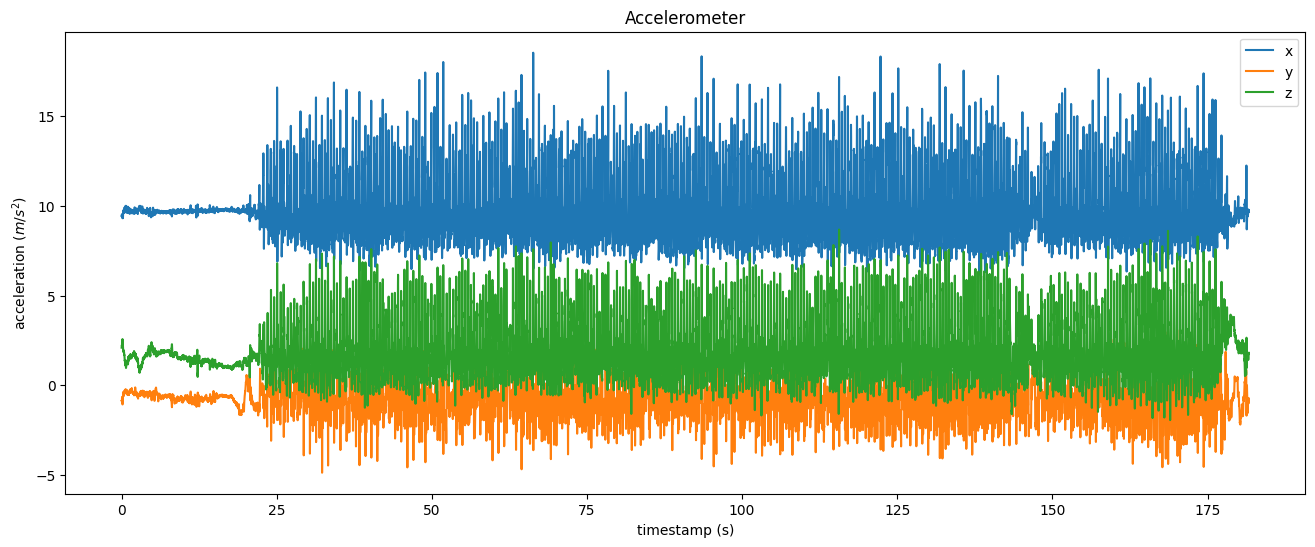

In [4]:
plt.plot(acc.ts, acc[["x", "y", "z"]], label=["x", "y", "z"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer")
plt.legend()
plt.show()


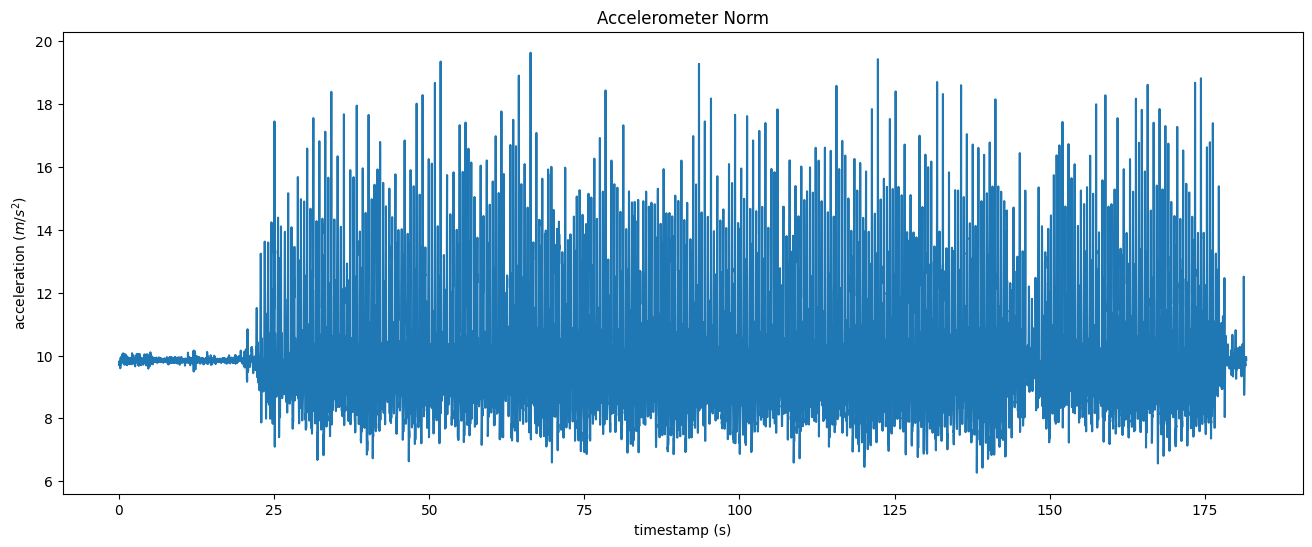

In [5]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)
acc.reset_index()

plt.plot(acc.ts, acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

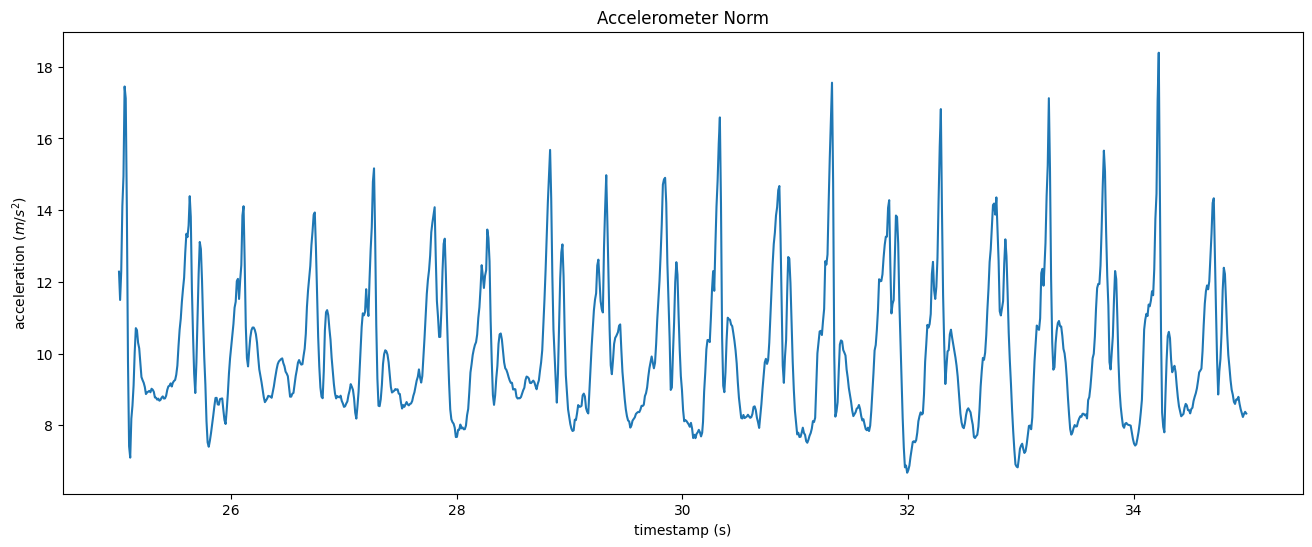

In [6]:

acc['norm'] = np.sqrt(acc['x']**2+acc['y']**2+acc['z']**2)

# 時間が25秒以上50秒未満のデータを抽出
time_filter_acc = acc[(acc.ts >= 25) & (acc.ts < 35)]
time_filter_acc.reset_index(inplace=True, drop=True)

plt.plot(time_filter_acc.ts, time_filter_acc['norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_95215/170683450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(


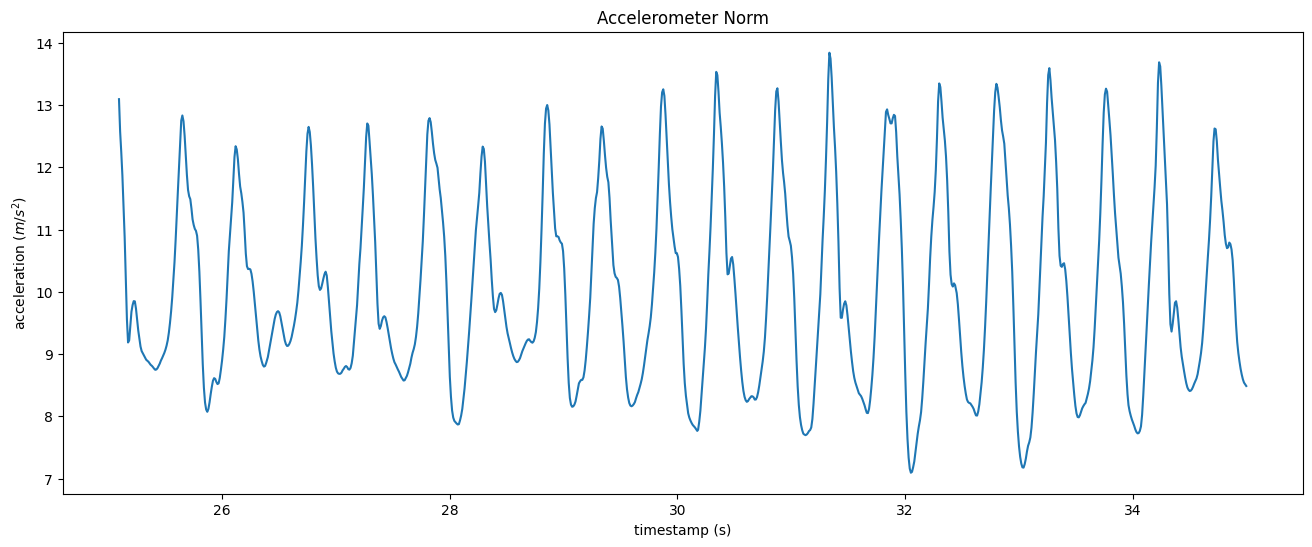

In [7]:

# 移動平均フィルターをかける
time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(
    10).mean()

plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

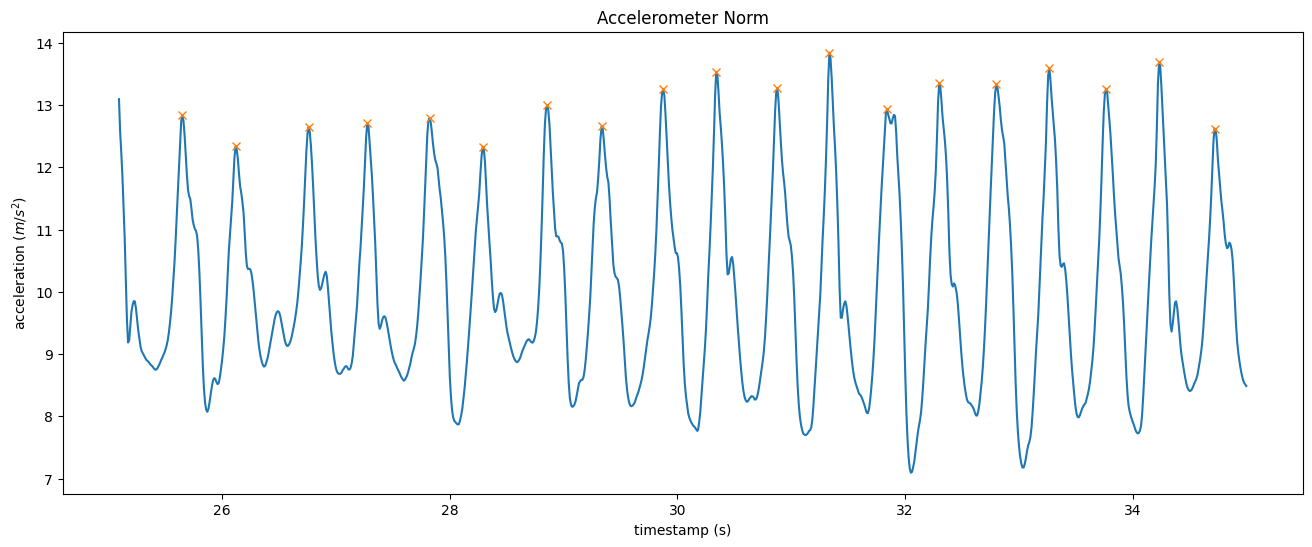

In [8]:
# ピーク検出
from scipy.signal import find_peaks

peaks, _ = find_peaks(time_filter_acc['rolling_norm'], height=12, distance=10)
plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
plt.plot(time_filter_acc.ts[peaks],
         time_filter_acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()


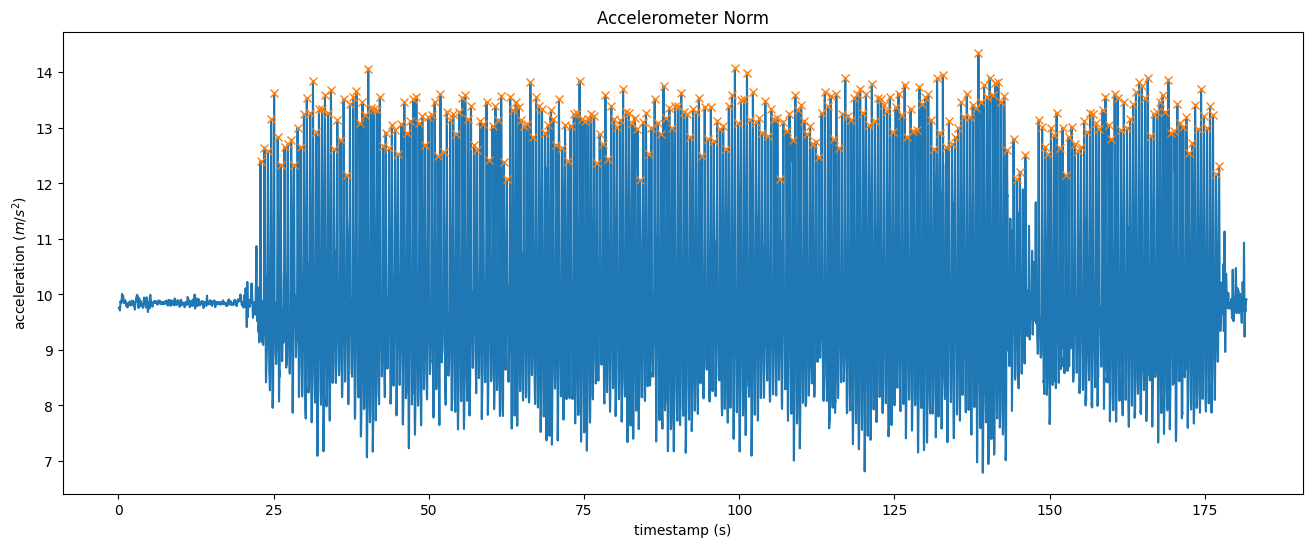

In [9]:

acc['rolling_norm'] = acc['norm'].rolling(10).mean()

peaks, _ = find_peaks(acc['rolling_norm'], height=12, distance=10)
plt.plot(acc.ts, acc['rolling_norm'])
plt.plot(acc.ts[peaks], acc['rolling_norm'][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()



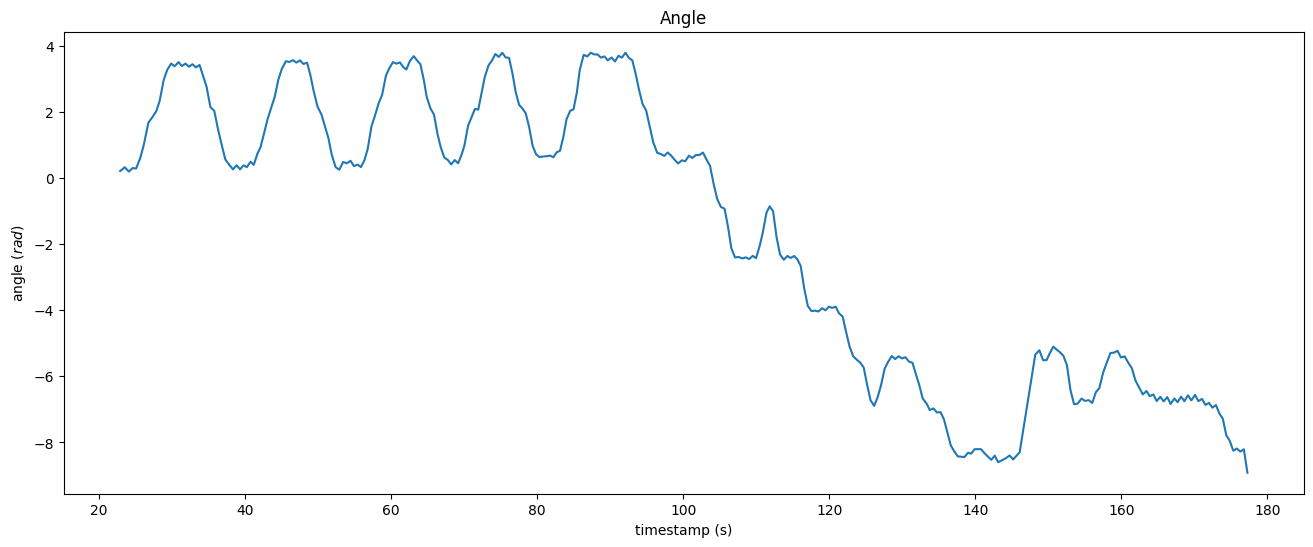

In [10]:

gyro_in_step_timing = pd.DataFrame()
gyro_in_step_timing = estimate.match_data(gyro, acc.ts[peaks])


# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()
angle_in_step_timing= estimate.convert_to_peek_angle(gyro, acc, peaks)

plt.plot(angle_in_step_timing.ts, angle_in_step_timing['x'])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

FLU01


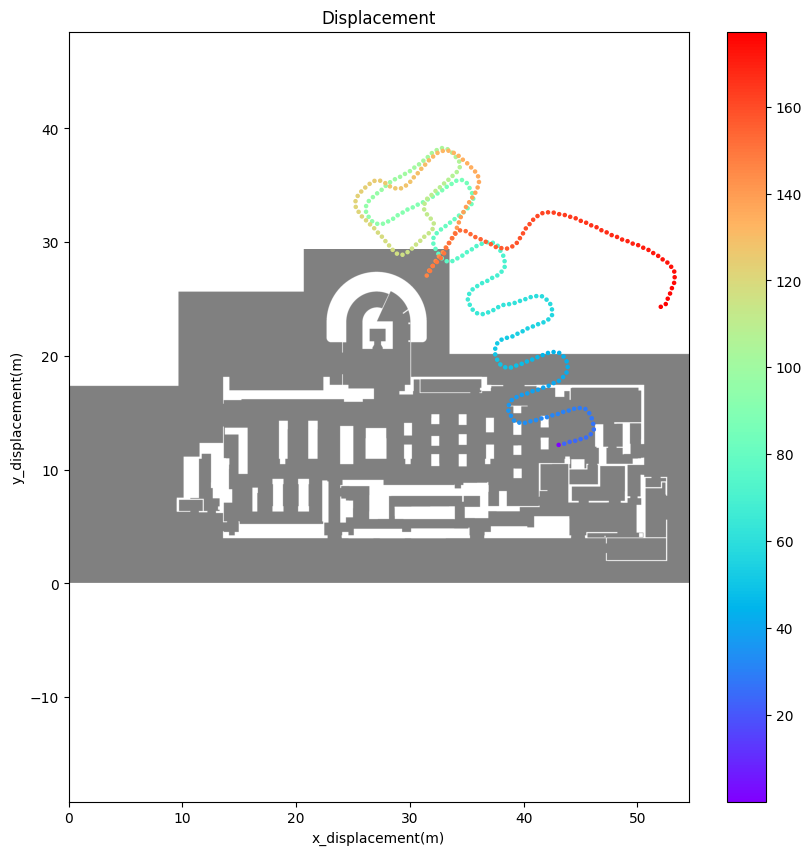

In [11]:
# 1 pixel of bmp represents 0.01 m
dx = 0.01
dy = 0.01

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp")


floor_name = gt_ref['floor'].values[0]
print(floor_name)

estimate.plot_map(map_dict,floor_name, dx, dy)

peek_angle = estimate.convert_to_peek_angle(gyro,acc,peaks)
cumulative_displacement_df = estimate.calculate_cumulative_displacement(peek_angle.ts, peek_angle['x'], 0.5, {"x":gt_ref.x[0],"y":gt_ref.y[0]},gt_ref['%time'][0])

plt.colorbar(
    plt.scatter(cumulative_displacement_df.x_displacement, cumulative_displacement_df.y_displacement, c=cumulative_displacement_df.ts, cmap="rainbow",s=5))

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



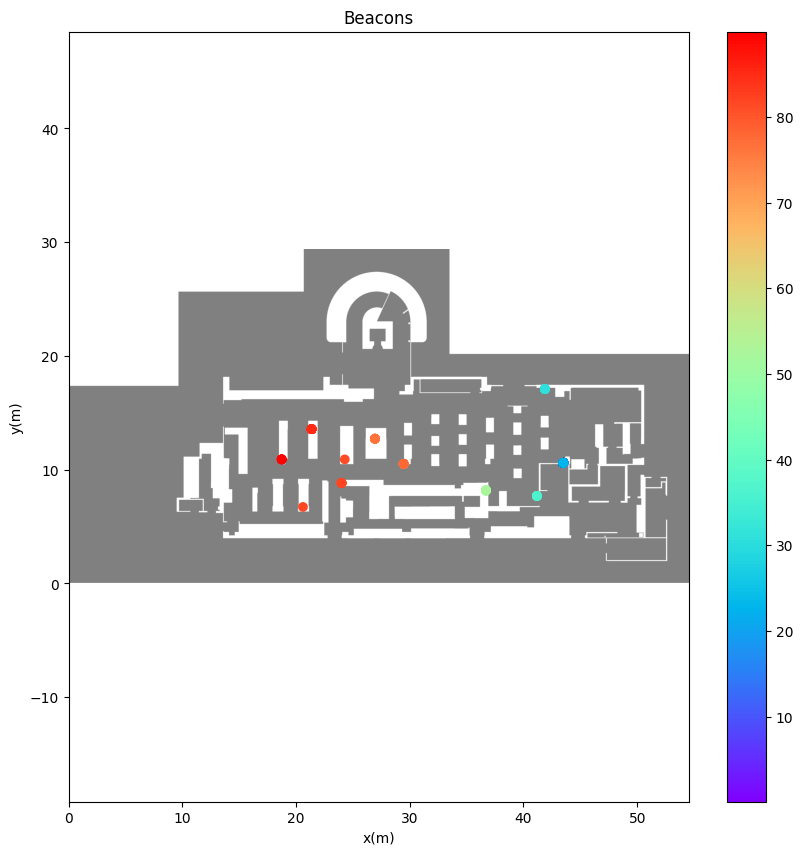

In [12]:

import numpy as np
import pandas as pd


# 軌跡前半の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索
# これは軌跡前半はドリフトが乗りづらいため
#時間全体の中央を変数に入れる

center_of_time = blescans.tail(1)['ts'].values[0]/2

first_half_strong_blescans= estimate.filter_strong_blescans(blescans,center_of_time,-76)
merged_strong_blescans_first_half = estimate.load_beacons_and_merge(BEACON_LIST_PATH, first_half_strong_blescans)


# マップ上にビーコンの位置をプロット
estimate.plot_map(map_dict,floor_name, dx, dy)

plt.colorbar(
    plt.scatter(merged_strong_blescans_first_half.x, merged_strong_blescans_first_half.y, c=merged_strong_blescans_first_half['ts'], cmap="rainbow"))

plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("Beacons")
plt.show()



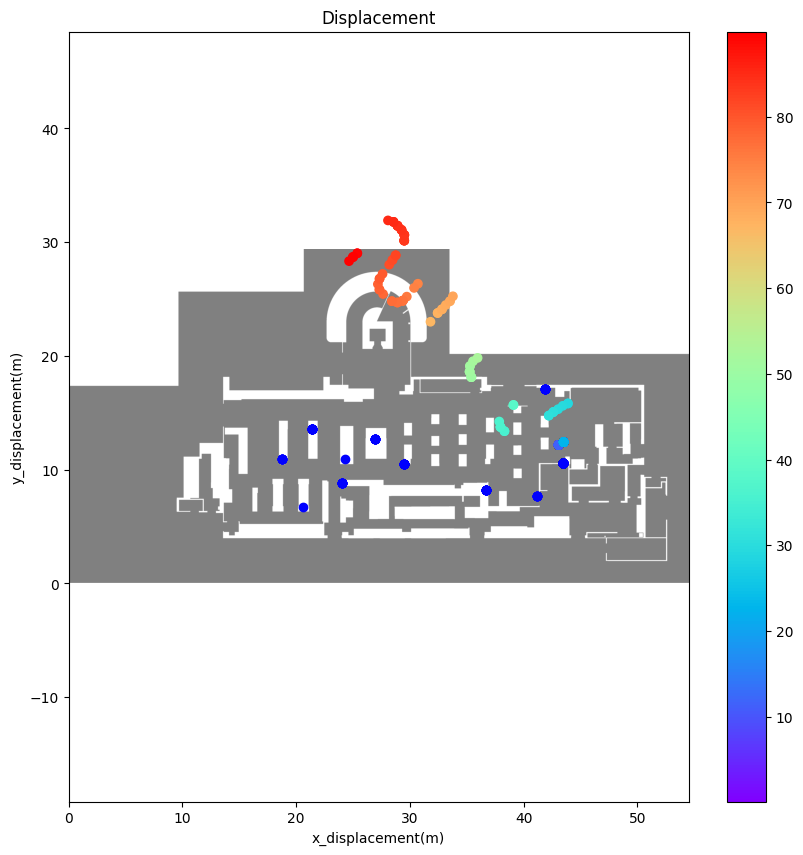

In [13]:

rotated_cumulative_displacement_df =estimate.rotate_cumulative_displacement(
    cumulative_displacement_df, 0.3,         
    {"x": gt_ref.x[0], "y": gt_ref.y[0]})


# 同じ bdaddress, x, y を持つデータをグループ化
merged_df = pd.merge_asof(merged_strong_blescans_first_half, rotated_cumulative_displacement_df, on='ts',direction="nearest")
# マップ上にx_displacement,y_displacementとビーコンの位置をプロット
estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(merged_df.x_displacement, merged_df.y_displacement, c=merged_df['ts'], cmap="rainbow"))
plt.scatter(merged_df.x, merged_df.y, c="blue")

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

[{'angle': 0.0, 'total_euclidean_distance': 6974.738051575003}, {'angle': 0.01, 'total_euclidean_distance': 6929.742886549255}, {'angle': 0.02, 'total_euclidean_distance': 6884.587104588034}, {'angle': 0.03, 'total_euclidean_distance': 6839.272034250063}, {'angle': 0.04, 'total_euclidean_distance': 6793.799014680858}, {'angle': 0.05, 'total_euclidean_distance': 6748.169395876048}, {'angle': 0.06, 'total_euclidean_distance': 6702.384538959443}, {'angle': 0.07, 'total_euclidean_distance': 6656.445816476828}, {'angle': 0.08, 'total_euclidean_distance': 6610.354612706631}, {'angle': 0.09, 'total_euclidean_distance': 6564.112323988568}, {'angle': 0.1, 'total_euclidean_distance': 6517.720359071613}, {'angle': 0.11, 'total_euclidean_distance': 6471.180139482577}, {'angle': 0.12, 'total_euclidean_distance': 6424.493099916843}, {'angle': 0.13, 'total_euclidean_distance': 6377.660688652777}, {'angle': 0.14, 'total_euclidean_distance': 6330.684367991596}, {'angle': 0.15, 'total_euclidean_distance

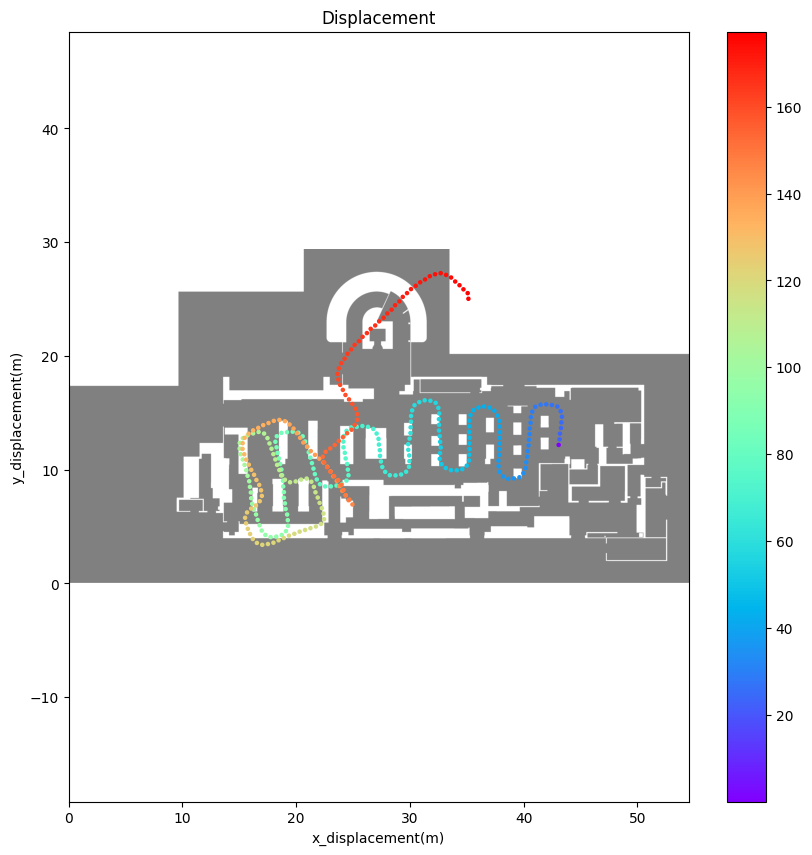

In [14]:

angle=estimate.search_optimal_angle(cumulative_displacement_df,gt_ref,merged_strong_blescans_first_half)


rotate_by_first_half_angle= pd.DataFrame({
    "ts":angle_in_step_timing.ts,
    "x":angle_in_step_timing.x+angle
})

rotate_by_first_half_angle_displacement = estimate.calculate_cumulative_displacement(
    rotate_by_first_half_angle.ts, rotate_by_first_half_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_first_half_angle_displacement.x_displacement, rotate_by_first_half_angle_displacement.y_displacement,
                c=rotate_by_first_half_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



[{'drift': 0.005999999999999986, 'euclidean_distance': 2.3621569826188407}, {'drift': 0.006999999999999987, 'euclidean_distance': 2.990830227520107}, {'drift': 0.004999999999999987, 'euclidean_distance': 3.7855274444223093}, {'drift': 0.007999999999999985, 'euclidean_distance': 4.937391045348897}, {'drift': 0.003999999999999988, 'euclidean_distance': 5.923504550582676}, {'drift': 0.008999999999999982, 'euclidean_distance': 7.188472715238833}, {'drift': 0.002999999999999989, 'euclidean_distance': 8.221250465440406}, {'drift': 0.0019999999999999896, 'euclidean_distance': 10.555449199347706}, {'drift': 0.0009999999999999905, 'euclidean_distance': 12.884537906649982}, {'drift': -8.673617379884035e-18, 'euclidean_distance': 15.187806798792554}, {'drift': -0.0010000000000000078, 'euclidean_distance': 17.451706045855406}, {'drift': -0.002000000000000007, 'euclidean_distance': 19.665744909371615}, {'drift': -0.003000000000000006, 'euclidean_distance': 21.820998152891818}, {'drift': -0.00400000

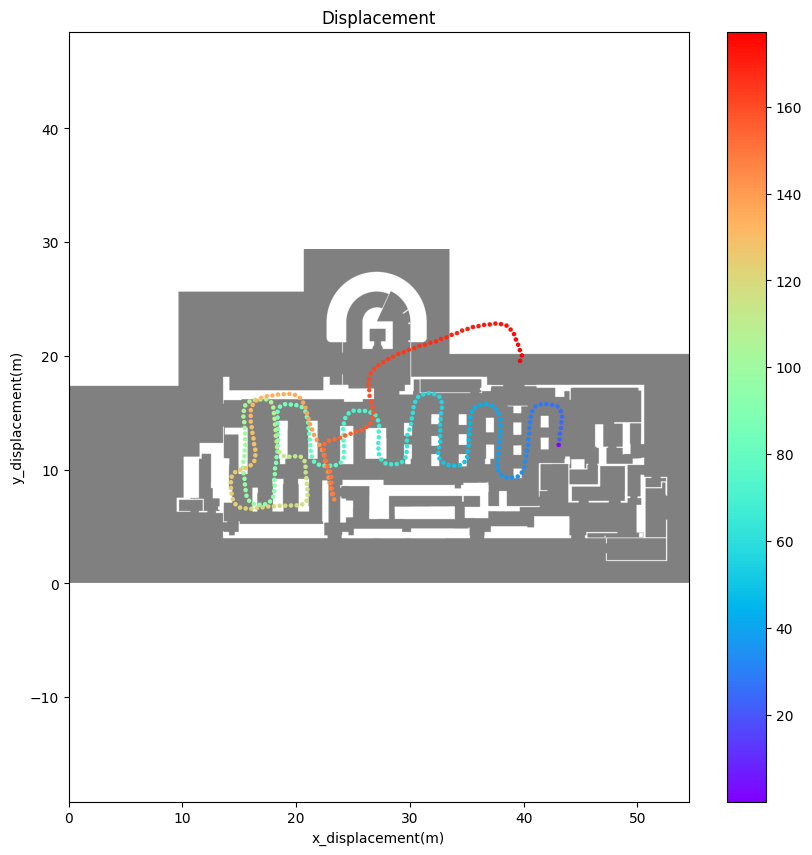

In [15]:
optimal_drift_and_euclidean=estimate.search_optimal_drift_from_angle(rotate_by_first_half_angle,gt_ref)


# first_time_remove_drift_angle= pd.DataFrame({
    # "ts":rotate_by_first_half_angle.ts,
    # "x":rotate_by_first_half_angle.x-optimal_drift_and_euclidean['drift']*(rotate_by_first_half_angle.ts-rotate_by_first_half_angle.ts.iloc[0])
# })

first_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_first_half_angle.ts,
    "x":rotate_by_first_half_angle.x-0.002999999999999989*(rotate_by_first_half_angle.ts-rotate_by_first_half_angle.ts.iloc[0])
})


first_time_remove_drift_angle_displacement = estimate.calculate_cumulative_displacement(
    first_time_remove_drift_angle.ts, first_time_remove_drift_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(first_time_remove_drift_angle_displacement.x_displacement, first_time_remove_drift_angle_displacement.y_displacement,
                c=first_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



[{'angle': 0.0, 'total_euclidean_distance': 1319.2951442432704}, {'angle': 0.01, 'total_euclidean_distance': 1297.456493707221}, {'angle': 0.02, 'total_euclidean_distance': 1279.0207218639243}, {'angle': 0.03, 'total_euclidean_distance': 1263.680677282738}, {'angle': 0.04, 'total_euclidean_distance': 1251.1978491734444}, {'angle': 0.05, 'total_euclidean_distance': 1241.5071416393514}, {'angle': 0.06, 'total_euclidean_distance': 1234.733876362735}, {'angle': 0.07, 'total_euclidean_distance': 1230.6727490409585}, {'angle': 0.08, 'total_euclidean_distance': 1229.338745183432}, {'angle': 0.09, 'total_euclidean_distance': 1230.5675503437415}, {'angle': 0.1, 'total_euclidean_distance': 1234.2992100550441}, {'angle': 0.11, 'total_euclidean_distance': 1240.4456593662653}, {'angle': 0.12, 'total_euclidean_distance': 1248.869754046561}, {'angle': 0.13, 'total_euclidean_distance': 1259.4297181132229}, {'angle': 0.14, 'total_euclidean_distance': 1271.8106789552996}, {'angle': 0.15, 'total_euclidea

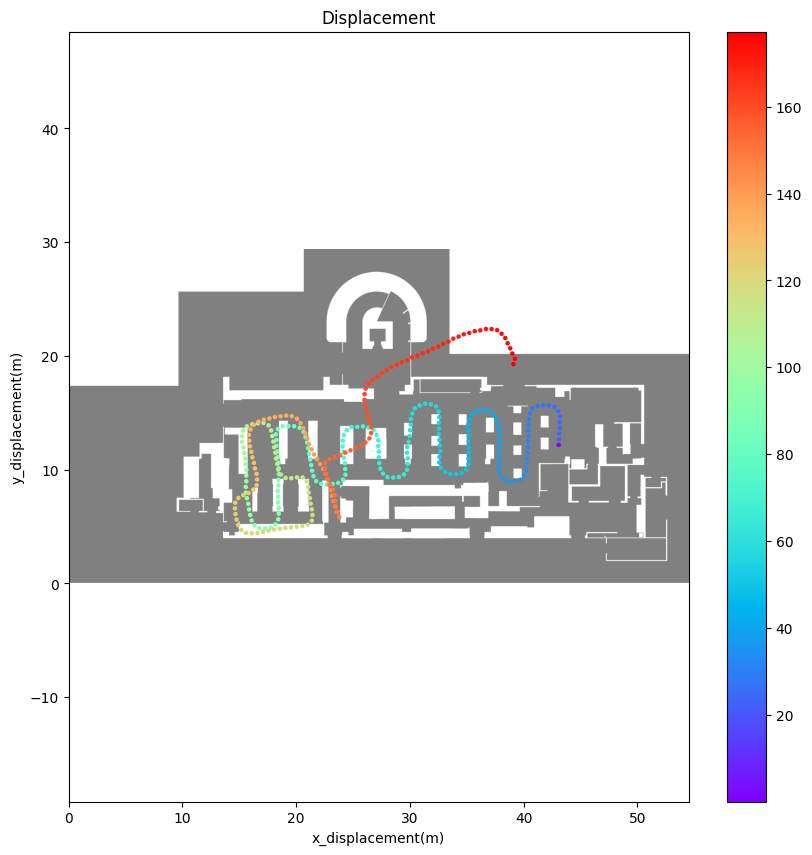

In [16]:
# 軌跡全体の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索見つける
overall_strong_blescans= estimate.filter_strong_blescans(blescans,blescans.tail(1)['ts'].values[0],-76)
merged_strong_blescans_overall = estimate.load_beacons_and_merge(BEACON_LIST_PATH, overall_strong_blescans)

overall_strong_ble_angle = estimate.search_optimal_angle(first_time_remove_drift_angle_displacement,gt_ref,merged_strong_blescans_overall)

rotate_by_overall_strong_ble_angle= pd.DataFrame({
    "ts":first_time_remove_drift_angle.ts,
    "x":first_time_remove_drift_angle.x+overall_strong_ble_angle
})


rotate_by_overall_strong_ble_angle_displacement = estimate.calculate_cumulative_displacement(
    rotate_by_overall_strong_ble_angle.ts, rotate_by_overall_strong_ble_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(rotate_by_overall_strong_ble_angle_displacement.x_displacement, rotate_by_overall_strong_ble_angle_displacement.y_displacement,
                c=rotate_by_overall_strong_ble_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()



[{'drift': 0.002999999999999989, 'euclidean_distance': 2.3585355579323606}, {'drift': 0.003999999999999988, 'euclidean_distance': 2.9839789043791867}, {'drift': 0.0019999999999999896, 'euclidean_distance': 3.785899447253837}, {'drift': 0.004999999999999987, 'euclidean_distance': 4.930490762524594}, {'drift': 0.0009999999999999905, 'euclidean_distance': 5.925046417380079}, {'drift': 0.005999999999999986, 'euclidean_distance': 7.181660988672185}, {'drift': -8.673617379884035e-18, 'euclidean_distance': 8.223002986857615}, {'drift': 0.006999999999999987, 'euclidean_distance': 9.505152483919261}, {'drift': -0.0010000000000000078, 'euclidean_distance': 10.557065484240121}, {'drift': 0.007999999999999985, 'euclidean_distance': 11.837305675555115}, {'drift': -0.002000000000000007, 'euclidean_distance': 12.885855229997395}, {'drift': 0.008999999999999982, 'euclidean_distance': 14.151152943997841}, {'drift': -0.003000000000000006, 'euclidean_distance': 15.188734093053462}, {'drift': -0.004000000

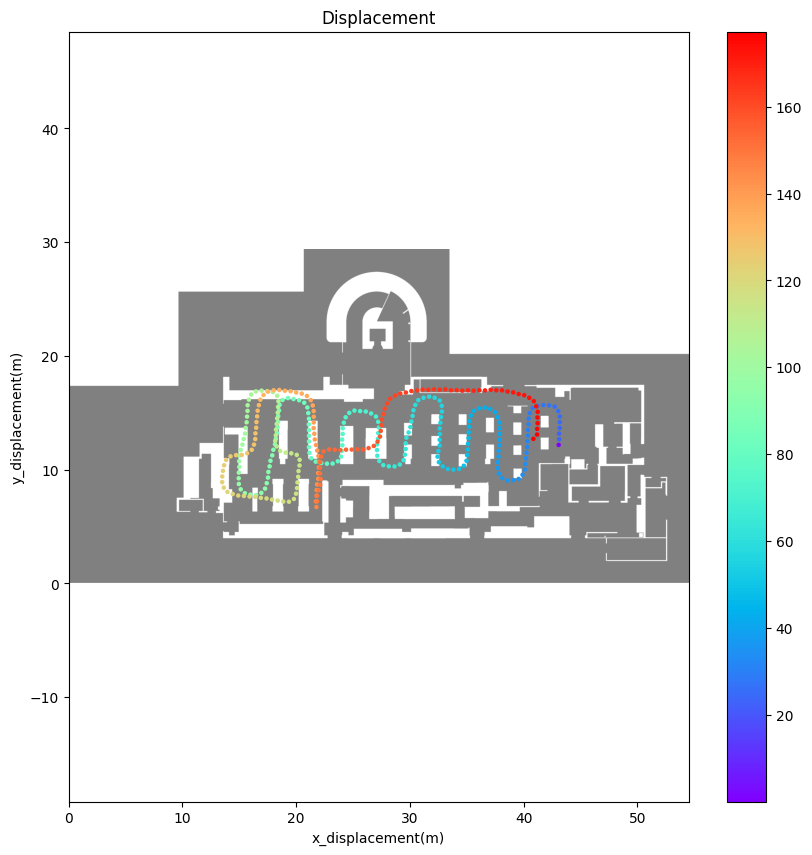

In [17]:

second_optimal_drift_and_euclidean=estimate.search_optimal_drift_from_angle(rotate_by_overall_strong_ble_angle,gt_ref)

second_time_remove_drift_angle= pd.DataFrame({
    "ts":rotate_by_overall_strong_ble_angle.ts,
    "x":rotate_by_overall_strong_ble_angle.x-second_optimal_drift_and_euclidean['drift']*(rotate_by_overall_strong_ble_angle.ts-rotate_by_overall_strong_ble_angle.ts.iloc[0])
})

second_time_remove_drift_angle_displacement = estimate.calculate_cumulative_displacement(
    second_time_remove_drift_angle.ts, second_time_remove_drift_angle['x'], 0.5, {"x": gt_ref.x[0], "y": gt_ref.y[0]},gt_ref['%time'][0])

estimate.plot_map(map_dict,floor_name, dx, dy)
plt.colorbar(
    plt.scatter(second_time_remove_drift_angle_displacement.x_displacement, second_time_remove_drift_angle_displacement.y_displacement,
                c=second_time_remove_drift_angle_displacement.ts, cmap="rainbow",s=5))
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()





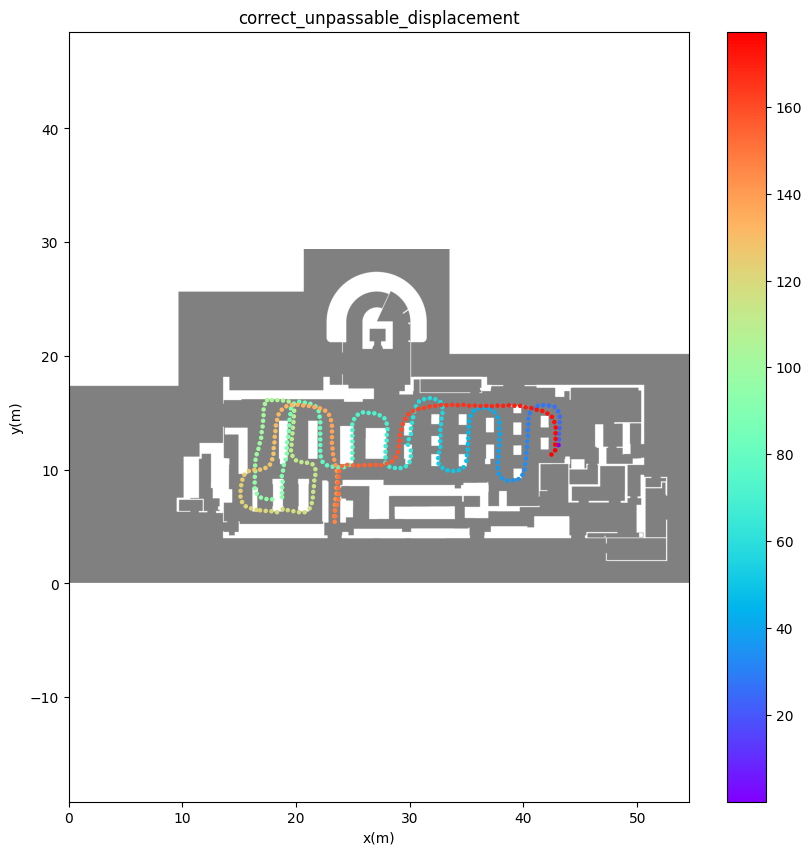

In [18]:

np.set_printoptions(threshold=np.inf)

correct_unpassable_displacement = estimate.correct_unpassable_points(second_time_remove_drift_angle_displacement[second_time_remove_drift_angle_displacement['ts']<180], map_dict, floor_name, dx, dy)

estimate.plot_map(
    map_dict,
    floor_name,
    dx,
    dy,
)

plt.colorbar(
    plt.scatter(
        correct_unpassable_displacement['x_displacement'],
        correct_unpassable_displacement['y_displacement'],
        c=correct_unpassable_displacement['ts'],
        cmap='rainbow',
        s=5
    )
)


plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.title('correct_unpassable_displacement')
plt.show()



output_df = pd.DataFrame({
    'ts': correct_unpassable_displacement['ts'],
    'x': correct_unpassable_displacement['x_displacement'],
    'y': correct_unpassable_displacement['y_displacement'],
    'floor': floor_name
})




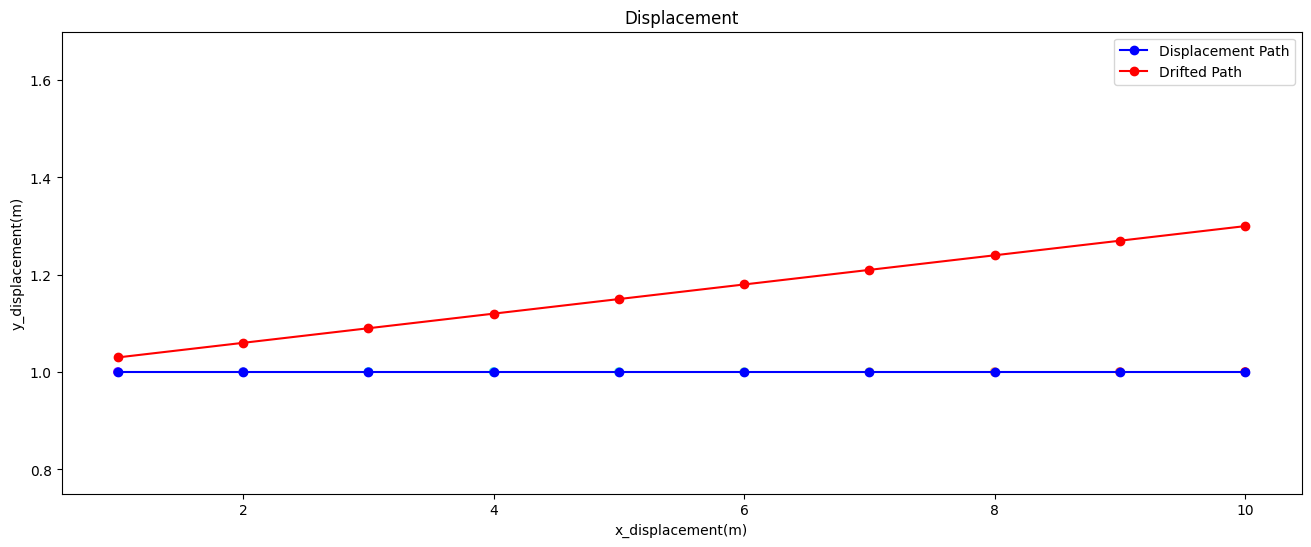

In [19]:

import pandas as pd
import matplotlib.pyplot as plt

displacement_df = pd.DataFrame({
    'x': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'y': [1,1,1,1,1,1,1,1,1,1]
})

# 最後のドリフト値を0.1とする
final_drift_value = 0.3
drifted_y = displacement_df.y + final_drift_value * (displacement_df.x / displacement_df.x.max())

# Plot the line connecting the points
plt.plot(displacement_df.x, displacement_df.y, '-o', label='Displacement Path', color='blue')
plt.plot(displacement_df.x, drifted_y, '-o', label='Drifted Path', color='red')

# y-axis limit
plt.ylim(0.75, 1.7)

# Scatter plot
plt.scatter(displacement_df.x, displacement_df.y, c=displacement_df.index, cmap="rainbow")

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.legend()
plt.show()



